Preparing the 3 Class Data JSON From COCO Dataset

Train Set JSON

In [1]:
import json 

with open(r"C:\Users\metec\OneDrive\Masaüstü\coco2017\annotations\instances_train2017.json") as f:
    data = json.load(f)

#finding the target class ids
target_classes = ["car", "bus", "motorcycle"]
category_ids = [c["id"] for c in data["categories"] if c["name"] in target_classes]
print(category_ids)

#bounding box 
filtered_annotations = [ann for ann in data["annotations"] if ann["category_id"] in category_ids]
filtered_image_ids = set([ann["image_id"] for ann in filtered_annotations])

#image 
filtered_images = [img for img in data["images"] if img["id"] in filtered_image_ids]

filtered_data = {
    "images": filtered_images,
    "annotations": filtered_annotations,
    "categories": [c for c in data["categories"] if c["id"] in category_ids]
}

with open(r"C:\Users\metec\OneDrive\Masaüstü\coco2017\annotations\filtered_instances_train2017_3class.json", "w") as f:
    json.dump(filtered_data, f)


print("New 3 class test set json is created")

[3, 4, 6]
New 3 class test set json is created


Validation Set JSON

In [2]:
import json

with open(r"C:\Users\metec\OneDrive\Masaüstü\coco2017\annotations\instances_val2017.json") as f:
    data = json.load(f)

target_classes = ["car", "bus", "motorcycle"]

category_ids = [c["id"] for c in data["categories"] if c["name"] in target_classes]

#bounding box 
filtered_annotations = [ann for ann in data["annotations"] if ann["category_id"] in category_ids]
filtered_image_ids = set([ann["image_id"] for ann in filtered_annotations])

#image
filtered_images = [img for img in data["images"] if img["id"] in filtered_image_ids]

filtered_data = {
    "images": filtered_images,
    "annotations": filtered_annotations,
    "categories": [c for c in data["categories"] if c["id"] in category_ids]
}

with open(r"C:\Users\metec\OneDrive\Masaüstü\coco2017\annotations\filtered_instances_val2017_3class.json", "w") as f:
    json.dump(filtered_data, f)

print("New 3 class val set json is created")


New 3 class val set json is created


Block For Manuel Test

In [3]:
import json

# COCO annotations file path
ann_path = r"C:\Users\metec\OneDrive\Masaüstü\coco2017\annotations\instances_train2017.json"

# image ID
target_id = 539259

# JSON
with open(ann_path, 'r') as f:
    coco = json.load(f)

# Image info
image_info = next((img for img in coco['images'] if img['id'] == target_id), None)

if image_info:
    print(f"File name: {image_info['file_name']}")
    print(f"Width x Height: {image_info['width']} x {image_info['height']}")
    print(f"COCO URL: http://images.cocodataset.org/train2017/{image_info['file_name']}")
else:
    print("Image cannot found")

# Annotations
annotations = [ann for ann in coco['annotations'] if ann['image_id'] == target_id]
print(f"This image consist of {len(annotations)} annotations")

# Annotation class ID
cat_ids = set(ann['category_id'] for ann in annotations)
print(f"Category IDs: {cat_ids}")

# Categories
cat_names = [cat['name'] for cat in coco['categories'] if cat['id'] in cat_ids]
print(f"Class Names: {cat_names}")


File name: 000000539259.jpg
Width x Height: 375 x 500
COCO URL: http://images.cocodataset.org/train2017/000000539259.jpg
This image consist of 7 annotations
Category IDs: {1, 3, 10, 11, 77, 31}
Class Names: ['person', 'car', 'traffic light', 'fire hydrant', 'handbag', 'cell phone']


COCO to YOLO Type Creating the 3 Class Dataset

In [4]:
import os
import json
import shutil
from collections import defaultdict

COCO_ROOT = r"C:\Users\metec\OneDrive\Masaüstü\coco2017" 
TRAIN_JSON = r"C:\Users\metec\OneDrive\Masaüstü\coco2017\annotations\filtered_instances_train2017_3class.json"
VAL_JSON   = r"C:\Users\metec\OneDrive\Masaüstü\coco2017\annotations\filtered_instances_val2017_3class.json"

OUT_ROOT = r"C:\YAP470_Dataset"
#YAP470-> train & val-> images & labels -> .txt (class_id x_center y_center width height)


COCO_TRAIN_IMG_DIR = os.path.join(COCO_ROOT, "train2017")
COCO_VAL_IMG_DIR   = os.path.join(COCO_ROOT, "val2017")

TARGET_CLASS_ORDER = ["car", "bus", "motorcycle"]

# {'car':0, 'bus':1, 'motorcycle':2}
YOLO_CLASS_TO_ID = {name: i for i, name in enumerate(TARGET_CLASS_ORDER)}  

def make_dirs(split_root):
    os.makedirs(os.path.join(split_root, "images"), exist_ok=True)
    os.makedirs(os.path.join(split_root, "labels"), exist_ok=True)
    

def to_yolo_bbox(bbox, img_w, img_h):
    # COCO: [x_min, y_min, w, h] → YOLO: [x_c/img_w, y_c/img_h, w/img_w, h/img_h]
    x, y, w, h = bbox

    # negatif, sıfır genişlik/yükseklik 
    if w <= 0 or h <= 0:
        return None

    # x_center ve y_center
    x_center = (x + w / 2.0) / img_w
    y_center = (y + h / 2.0) / img_h
    w /= img_w
    h /= img_h

    #normalizasyon
    x_center = max(0.0, min(1.0, x_center))
    y_center = max(0.0, min(1.0, y_center))
    w = max(0.0, min(1.0, w))
    h = max(0.0, min(1.0, h))

    # eğer kutu görüntü dışında kalmışsa None döndür
    if w == 0 or h == 0:
        return None

    return x_center, y_center, w, h

def process_split(json_path, coco_img_dir, out_split_dir):
    make_dirs(out_split_dir)
    
    with open(json_path, "r", encoding="utf-8") as f:
        coco = json.load(f)
    
    #{3: "car", 4: "motorcycle", 6: "bus"}
    catid_to_name = {c["id"]: c["name"] for c in coco["categories"]}
    
    
    #cocoid:yoloid -> {3: 0, 6: 1, 4: 2}
    catid_to_yolo = {}
    for cid, cname in catid_to_name.items():
        if cname not in YOLO_CLASS_TO_ID:
            continue
        catid_to_yolo[cid] = YOLO_CLASS_TO_ID[cname]

    '''anns_by_img = {
        1: [ {car box}, {motor box} ],
        2: [ {bus box} ]
        }'''
    anns_by_img = defaultdict(list)
    for ann in coco["annotations"]:
        if ann.get("iscrowd", 0) == 1:
            continue
        if ann["category_id"] not in catid_to_yolo:
            continue
        anns_by_img[ann["image_id"]].append(ann)

    for img in coco["images"]:
        img_id = img["id"]
        file_name = img["file_name"]
        width, height = img["width"], img["height"]

        ann_list = anns_by_img.get(img_id, [])
        if not ann_list:
            continue  

        # label dosyası yolu -> labels/000001.txt
        stem = os.path.splitext(file_name)[0]
        label_path = os.path.join(out_split_dir, "labels", f"{stem}.txt")

        #her boxun txtye yazimi -> 2 0.625000 0.300000 0.312500 0.208333 -> motorcycle
        with open(label_path, "w", encoding="utf-8") as lf:
            for ann in ann_list:
                yolo_id = catid_to_yolo[ann["category_id"]]
                box = to_yolo_bbox(ann["bbox"], width, height)
                if box is None:
                    continue
                x_c, y_c, w, h = box
                lf.write(f"{yolo_id} {x_c:.6f} {y_c:.6f} {w:.6f} {h:.6f}\n")

        # Görseli kopyala
        src_img = os.path.join(coco_img_dir, file_name)
        dst_img = os.path.join(out_split_dir, "images", file_name)
        os.makedirs(os.path.dirname(dst_img), exist_ok=True)
        try:
            shutil.copy2(src_img, dst_img)
        except FileNotFoundError:
            print(f"Image cannot found: {file_name}")
            continue

    print(f"{out_split_dir} passed.")


# TRAIN 
process_split(
    json_path=TRAIN_JSON,
    coco_img_dir=COCO_TRAIN_IMG_DIR,
    out_split_dir=os.path.join(OUT_ROOT, "train")
)

# VAL
process_split(
    json_path=VAL_JSON,
    coco_img_dir=COCO_VAL_IMG_DIR,
    out_split_dir=os.path.join(OUT_ROOT, "val")
)

print("Dataset is created")


C:\YAP470_Dataset\train passed.
C:\YAP470_Dataset\val passed.
Dataset is created


Creating the Additional 3 Class Dataset from "Vehicle Dataset for YOLO" Dataset  

In [5]:
import os, shutil

# ---------- TRAIN ----------
src_lbl= r"C:\Users\metec\OneDrive\Masaüstü\vehicle_dataset\train\labels"
src_img = r"C:\Users\metec\OneDrive\Masaüstü\vehicle_dataset\train\images"
dst_lbl = r"C:\Users\metec\OneDrive\Masaüstü\filtered_vehicle\train\labels"
dst_img = r"C:\Users\metec\OneDrive\Masaüstü\filtered_vehicle\train\images"

# ---------- VALID ----------
src_lbl_val= r"C:\Users\metec\OneDrive\Masaüstü\vehicle_dataset\valid\labels"
src_img_val = r"C:\Users\metec\OneDrive\Masaüstü\vehicle_dataset\valid\images"
dst_lbl_val = r"C:\Users\metec\OneDrive\Masaüstü\filtered_vehicle\valid\labels"
dst_img_val = r"C:\Users\metec\OneDrive\Masaüstü\filtered_vehicle\valid\images"

os.makedirs(dst_lbl, exist_ok=True); 
os.makedirs(dst_img, exist_ok=True)
os.makedirs(dst_lbl_val, exist_ok=True); 
os.makedirs(dst_img_val, exist_ok=True)

id_map = {"0": "0", "2": "1", "4": "2"}  #car(0)->0, bus(2)->1, motorbike(4)->2

def filter_dataset(src_lbl, src_img, dst_lbl, dst_img):
    for f in os.listdir(src_lbl):
        if not f.endswith(".txt"): continue
        # dosyayı satır satır oku, id 0, 2 veya 4 ise al
        lines = [l for l in open(f"{src_lbl}/{f}") if l.split()[0] in id_map]
        if not lines: 
            continue
        with open(f"{dst_lbl}/{f}", "w") as out:
            #id donusumu
            out.writelines(id_map[l.split()[0]] + " " + " ".join(l.split()[1:]) for l in lines)
        #image kopyalama
        for ext in (".jpg", ".png", ".jpeg"):
            p = f"{src_img}/{f[:-4]}{ext}"
            if os.path.exists(p): 
                shutil.copy(p, f"{dst_img}/{os.path.basename(p)}"); 
                break

# Train ve Valid datasetleri için filtreleme
filter_dataset(src_lbl, src_img, dst_lbl, dst_img)
filter_dataset(src_lbl_val, src_img_val, dst_lbl_val, dst_img_val)

print("2nd 3 Class Train and Valid Dataset is created")


2nd 3 Class Train and Valid Dataset is created


The First EDA for the 3 Class DatasetV1 

 Train klasöründeki toplam dosya sayısı: 16116
Class 0: 12251 görüntü
Class 1: 3952 görüntü
Class 2: 3502 görüntü

 Val klasöründeki toplam dosya sayısı: 717
Class 0: 535 görüntü
Class 1: 189 görüntü
Class 2: 159 görüntü

 Özet:
Class 0: Train=12251 | Val=535 | Toplam=12786
Class 1: Train=3952 | Val=189 | Toplam=4141
Class 2: Train=3502 | Val=159 | Toplam=3661


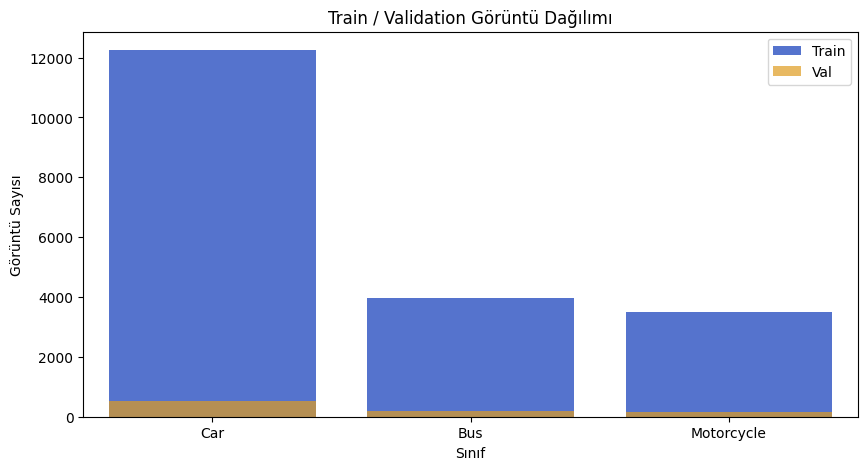


 EDA Gözlemleri:
- En çok örnek içeren sınıf: Car
- En az örnek içeren sınıf: Motorcycle


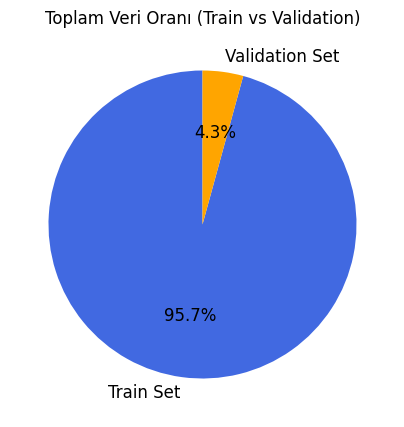

In [7]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

#  Veri yolları
train_labels = r"C:\YAP470_Dataset\train\labels"
val_labels   = r"C:\YAP470_Dataset\val\labels"


def count_images_per_class(label_dir):
    """Verilen label klasöründeki .txt dosyalarına göre sınıf başına kaç farklı görüntü olduğunu hesaplar."""
    counts = {}  # class_id -> kaç dosyada geçti
    total_files = 0

    for f in os.listdir(label_dir):
        if not f.endswith(".txt"):
            continue
        total_files += 1
        path = os.path.join(label_dir, f)
        with open(path, "r") as file:
            # her dosyadaki class id'leri (tekrarsız)
            ids = {line.strip().split()[0] for line in file if line.strip()}
        for cls_id in ids:
            counts[cls_id] = counts.get(cls_id, 0) + 1

    return counts, total_files



#  Sayımlar 

train_counts, train_total = count_images_per_class(train_labels)
val_counts, val_total = count_images_per_class(val_labels)


print(f" Train klasöründeki toplam dosya sayısı: {train_total}")
for cls_id, count in sorted(train_counts.items(), key=lambda x: int(x[0])):
    print(f"Class {cls_id}: {count} görüntü")

print(f"\n Val klasöründeki toplam dosya sayısı: {val_total}")
for cls_id, count in sorted(val_counts.items(), key=lambda x: int(x[0])):
    print(f"Class {cls_id}: {count} görüntü")

print("\n Özet:")
all_ids = sorted(set(train_counts.keys()) | set(val_counts.keys()), key=int)
summary_data = []
for cid in all_ids:
    tr = train_counts.get(cid, 0)
    va = val_counts.get(cid, 0)
    total = tr + va
    summary_data.append([cid, tr, va, total])
    print(f"Class {cid}: Train={tr} | Val={va} | Toplam={total}")


# Görselleştirme (EDA)

df = pd.DataFrame(summary_data, columns=["Class", "Train", "Val", "Total"])
df["Class Name"] = df["Class"].map({"0": "Car", "1": "Bus", "2": "Motorcycle"})

plt.figure(figsize=(10, 5))
sns.barplot(data=df, x="Class Name", y="Train", color="royalblue", label="Train")
sns.barplot(data=df, x="Class Name", y="Val", color="orange", alpha=0.7, label="Val")
plt.title("Train / Validation Görüntü Dağılımı")
plt.xlabel("Sınıf")
plt.ylabel("Görüntü Sayısı")
plt.legend()
plt.show()

max_class = df.loc[df["Total"].idxmax(), "Class Name"]
min_class = df.loc[df["Total"].idxmin(), "Class Name"]
ratio = round(df["Total"].max() / df["Total"].min(), 2)

print("\n EDA Gözlemleri:")
print(f"- En çok örnek içeren sınıf: {max_class}")
print(f"- En az örnek içeren sınıf: {min_class}")

#  Train–Val Oranı (Pie Chart)

plt.figure(figsize=(5, 5))
sizes = [train_total, val_total]
labels = ["Train Set", "Validation Set"]
colors = ["royalblue", "orange"]

plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    textprops={'fontsize': 12}
)
plt.title("Toplam Veri Oranı (Train vs Validation)")
plt.show()

Merging The Datasets (COCO and Vehicle Dataset for YOLO) DatasetV2

In [13]:
import os, shutil

# --- KAYNAK DATASET’LER ---
coco_root = r"C:\YAP470_Dataset"  # 3 Class COCO dataset
veh_root  = r"C:\Users\metec\OneDrive\Masaüstü\filtered_vehicle"  # 3 Class Vehicle Dataset for YOLO

# --- HEDEF (V2) DATASET ---
out_root  = r"C:\YAP470_Dataset_v2"

splits = ["train", "val"]
for split in splits:
    srcs = [os.path.join(coco_root, split), os.path.join(veh_root, split)]
    dst_lbl = os.path.join(out_root, split, "labels")
    dst_img = os.path.join(out_root, split, "images")
    os.makedirs(dst_lbl, exist_ok=True)
    os.makedirs(dst_img, exist_ok=True)
    
    # iki dataset kaynağını sırayla birleştir
    for src in srcs:
        lbl_dir = os.path.join(src, "labels")
        img_dir = os.path.join(src, "images")
        if not os.path.exists(lbl_dir):
            continue
        for f in os.listdir(lbl_dir):
            if not f.endswith(".txt"):
                continue
            src_lbl_path = os.path.join(lbl_dir, f)
            dst_lbl_path = os.path.join(dst_lbl, f)
            # Aynı isimde varsa "_veh" ekleyelim çakışmayı önlemek için
            if os.path.exists(dst_lbl_path):
                base, ext = os.path.splitext(f)
                dst_lbl_path = os.path.join(dst_lbl, f"{base}_veh{ext}")
            shutil.copy(src_lbl_path, dst_lbl_path)

            # aynı isimli görseli bul
            for ext in (".jpg", ".png", ".jpeg"):
                src_img_path = os.path.join(img_dir, f[:-4] + ext)
                if os.path.exists(src_img_path):
                    dst_img_path = os.path.join(dst_img, os.path.basename(src_img_path))
                    if os.path.exists(dst_img_path):
                        base, ext2 = os.path.splitext(dst_img_path)
                        dst_img_path = f"{base}_veh{ext2}"
                    shutil.copy(src_img_path, dst_img_path)
                    break
    print(f"{split} merged")

print("\nYAP470_Dataset_v2 is created")


train merged
val merged

YAP470_Dataset_v2 is created


The Second EDA for the Merged 3 Class DatasetV2 

Train Class 0: 12631 görüntü
Train Class 1: 4294 görüntü
Train Class 2: 3871 görüntü
Val Class 0: 704 görüntü
Val Class 1: 351 görüntü
Val Class 2: 321 görüntü

 Özet:
Class 0: Train=12631 | Val=704 | Toplam=13335
Class 1: Train=4294 | Val=351 | Toplam=4645
Class 2: Train=3871 | Val=321 | Toplam=4192


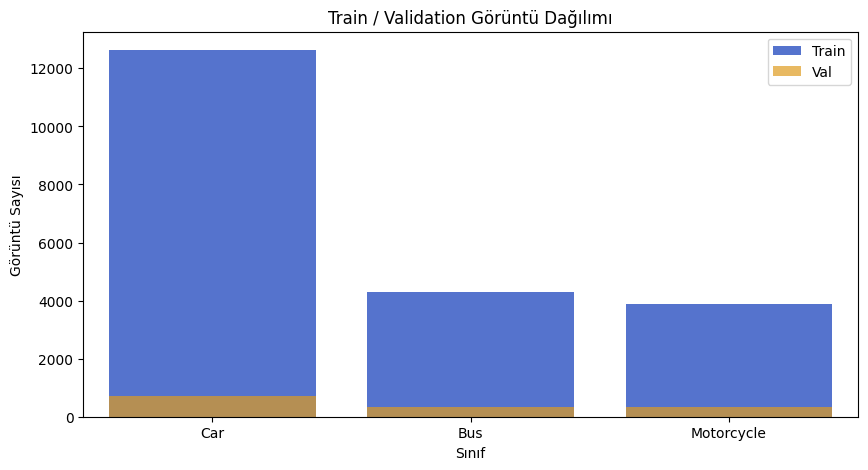


EDA Gözlemleri:
- En çok örnek içeren sınıf: Car
- En az örnek içeren sınıf: Motorcycle


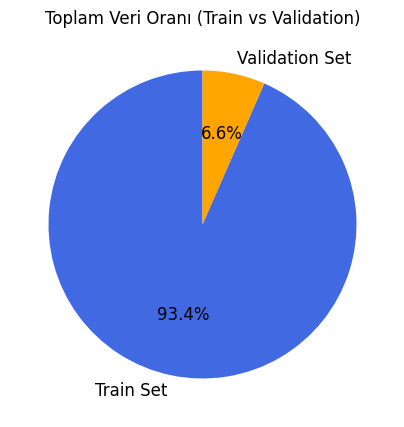

Selected image: 000000197716.jpg


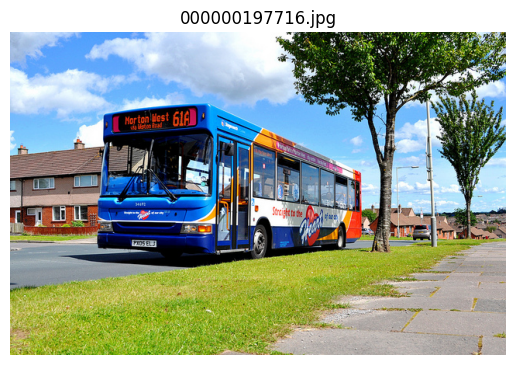

In [20]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Veri yolları
train_labels = r"C:\YAP470_Dataset_v2\train\labels"
val_labels   = r"C:\YAP470_Dataset_v2\val\labels"


def count_images_per_class(label_dir):
    """Verilen label klasöründeki .txt dosyalarına göre sınıf başına kaç farklı görüntü olduğunu hesaplar."""
    counts = {}  # class_id -> kaç dosyada geçti
    total_files = 0

    for f in os.listdir(label_dir):
        if not f.endswith(".txt"):
            continue
        total_files += 1
        path = os.path.join(label_dir, f)
        with open(path, "r") as file:
            # her dosyadaki class id'leri (tekrarsız)
            ids = {line.strip().split()[0] for line in file if line.strip()}
        for cls_id in ids:
            counts[cls_id] = counts.get(cls_id, 0) + 1

    return counts, total_files

# Sayımları al

train_counts, train_total = count_images_per_class(train_labels)
val_counts, val_total = count_images_per_class(val_labels)

for cls_id, count in sorted(train_counts.items(), key=lambda x: int(x[0])):
    print(f"Train Class {cls_id}: {count} görüntü")

for cls_id, count in sorted(val_counts.items(), key=lambda x: int(x[0])):
    print(f"Val Class {cls_id}: {count} görüntü")

print("\n Özet:")
all_ids = sorted(set(train_counts.keys()) | set(val_counts.keys()), key=int)
summary_data = []
for cid in all_ids:
    tr = train_counts.get(cid, 0)
    va = val_counts.get(cid, 0)
    total = tr + va
    summary_data.append([cid, tr, va, total])
    print(f"Class {cid}: Train={tr} | Val={va} | Toplam={total}")


#  Görselleştirme (EDA)

df = pd.DataFrame(summary_data, columns=["Class", "Train", "Val", "Total"])
df["Class Name"] = df["Class"].map({"0": "Car", "1": "Bus", "2": "Motorcycle"})

plt.figure(figsize=(10, 5))
sns.barplot(data=df, x="Class Name", y="Train", color="royalblue", label="Train")
sns.barplot(data=df, x="Class Name", y="Val", color="orange", alpha=0.7, label="Val")
plt.title("Train / Validation Görüntü Dağılımı")
plt.xlabel("Sınıf")
plt.ylabel("Görüntü Sayısı")
plt.legend()
plt.show()


max_class = df.loc[df["Total"].idxmax(), "Class Name"]
min_class = df.loc[df["Total"].idxmin(), "Class Name"]

print("\nEDA Gözlemleri:")
print(f"- En çok örnek içeren sınıf: {max_class}")
print(f"- En az örnek içeren sınıf: {min_class}")


# Train–Val Oranı (Pie Chart)

plt.figure(figsize=(5, 5))
sizes = [train_total, val_total]
labels = ["Train Set", "Validation Set"]
colors = ["royalblue", "orange"]

plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    textprops={'fontsize': 12}
)
plt.title("Toplam Veri Oranı (Train vs Validation)")
plt.show()

import random
from PIL import Image
images = os.listdir(r"C:\YAP470_Dataset_v2\train\images")
sample_img = random.choice(images)
print("Selected image:", sample_img)

# Görseli aç ve göster
img_path = os.path.join(r"C:\YAP470_Dataset_v2\train\images", sample_img)
img = Image.open(img_path)

plt.imshow(img)
plt.title(sample_img)
plt.axis("off")
plt.show()
